In [1]:
#from google.colab import drive
#drive.mount('/content/drive')


In [1]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from tensorflow.keras import mixed_precision
%matplotlib inline

In [2]:
train_data_dir = r'C:\Users\johns\Desktop\TFG\Dataset\train'
validation_data_dir = r'C:\Users\johns\Desktop\TFG\Dataset\valid'

In [3]:
width_shape = 224
height_shape = 224
epochs = 100
num_classes = len(os.listdir(train_data_dir))
batch_size = 32
image_shape = (224,224,3)


Found 12327 images belonging to 23 classes.
Found 2555 images belonging to 23 classes.


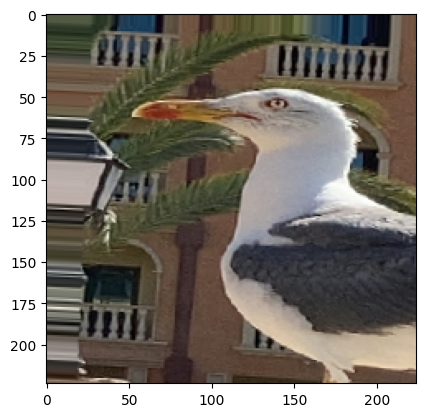

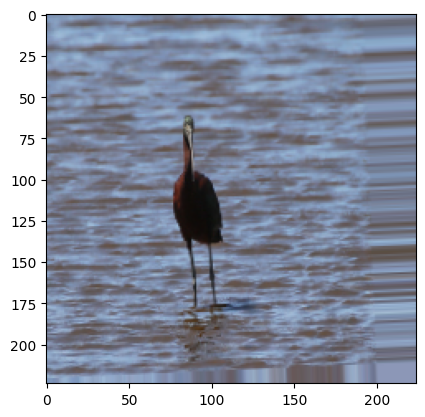

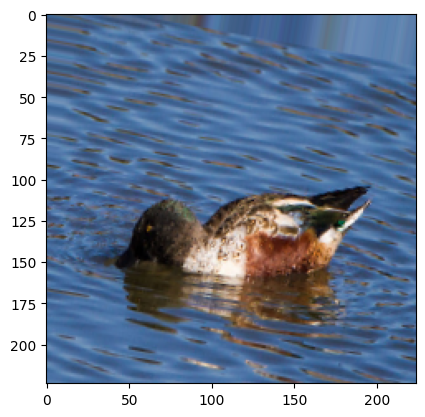

In [4]:
from keras.applications.resnet_v2 import preprocess_input

# Data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest', # Últimos cambios añadidos de una consulta
    )

valid_datagen = ImageDataGenerator(rescale=1./255) # Sin aumentos de datos para la validación

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True) # Activa y Desactiva el mezclado de los datos de prueba

validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True) # Activa y Desactiva el mezclado de los datos de prueba

for _ in range(3):
    img, label = next(train_generator)
    plt.imshow(img[0])
    plt.show()

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.resnet_v2 import ResNet152V2
from sklearn.utils.class_weight import compute_class_weight

# Fit the model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load pre-trained ResNet152V2 model
resnet_model=tf.keras.applications.ResNet152V2(input_shape=image_shape,
                                            include_top=False,
                                            weights='imagenet')

resnet_model.trainable = False

custom_resnet_model = keras.Sequential([
  resnet_model,
  layers.Flatten(),
  layers.Dense(units=1024, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(units=num_classes, activation="softmax"),
])

custom_resnet_model.summary()

# Compile the model
custom_resnet_model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert class weights to dictionary
class_weights_dict = dict(zip(np.unique(train_generator.classes), class_weights))

checkpoint = ModelCheckpoint(r'C:\Users\johns\Desktop\TFG\Dataset\RESNET152V2 - 23 clases\best_resnetv2_NAmodel.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# early_stop = EarlyStopping(monitor='val_loss', patience=10)

custom_resnet_model_history = custom_resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weights_dict
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 23)                23575     
                                                        

In [7]:
custom_resnet_model.save(r'C:\Users\johns\Desktop\TFG\Dataset\RESNET152V2 - 23 clases\custom_resnetv2_NAmodel.h5')

In [8]:
def plotTraining(hist, epochs, typeData):

    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-b',label='Training Validate')


    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18)
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

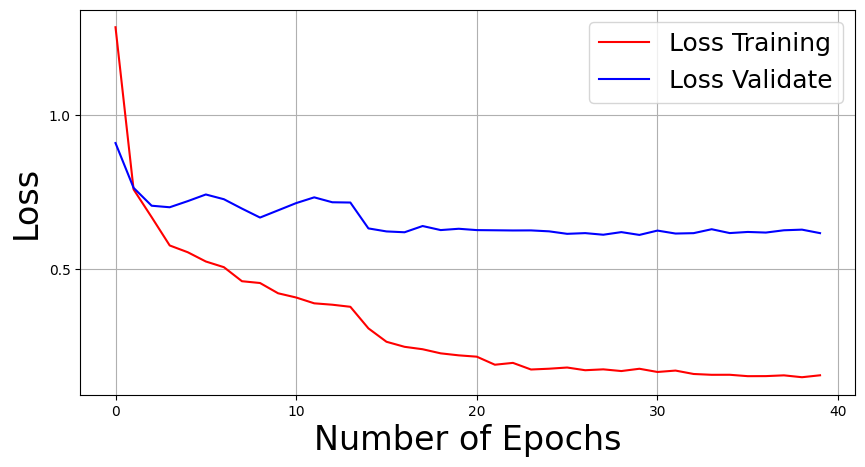

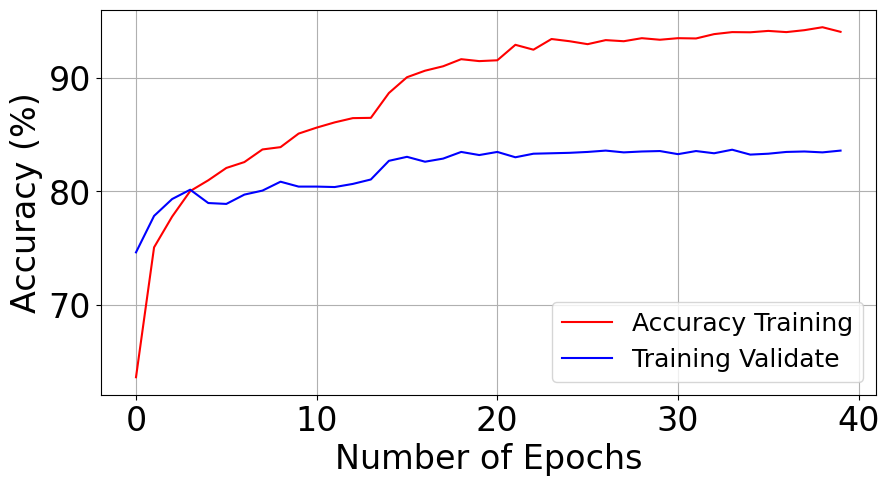

In [9]:
num_epochs_done = len(custom_resnet_model_history.history['loss'])

plotTraining(custom_resnet_model_history,num_epochs_done,"loss")
plotTraining(custom_resnet_model_history,num_epochs_done,"accuracy")
plotTraining(custom_resnet_model_history,num_epochs_done,"val_loss")
plotTraining(custom_resnet_model_history,num_epochs_done,"val_accuracy")

In [9]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

# nombres de las clases
names = ['AGUJA COLINERA',
          'ALCA COMÚN',
          'AVEFRÍA EUROPEA',
          'AVIÓN ROQUERO',
          'AVOCETA COMÚN',
          'CHARRÁN PATINEGRO',
          'CHORLITO DORADO EUROPEO',
          'ESTORNINO PINTO',
          'FLAMENCO COMUN',
          'FOCHA COMUN',
          'GARCILLA VUEYERA OCCIDENTAL',
          'GAVIOTA PATIAMARILLA',
          'GAVIOTA PICOFINA',
          'GAVIOTA REIDORA',
          'GOLONDRINA COMUN',
          'GORRIÓN COMÚN',
          'GRAJILLA OCCIDENTAL',
          'JILGUERO EUROPEO',
          'MORITO COMÚN',
          'PALOMA TORCAZ',
          'PARDELA BALEAR',
          'PATO CUCHARÓN NORTEÑO',
          'SERÍN VERDECILLO',
          'VENCEJO COMÚN']

# cargar el 
modelt = load_model(r"C:\Users\johns\Desktop\TFG\Dataset\RESNET152V2 - 23 clases\custom_resnetv2_NAmodel.h5")

# ruta de la imagen
imaget_path = r'C:\Users\johns\Desktop\TFG\Dataset\test\SERÍN VERDECILLO\1364.jpg'

# cargar y redimensionar la imagen
imaget = load_img(imaget_path, target_size=(width_shape, height_shape))
imaget = img_to_array(imaget)
imaget = imaget.reshape((1,) + imaget.shape)

# preprocesar la imagen
xt = imaget / 255.0  # Normalizar la imagen

# hacer predicciones
preds = modelt.predict(xt)

# obtener la clase predicha
predicted_class = np.argmax(preds)
class_name = names[predicted_class]

print(class_name)

# mostrar la imagen
plt.imshow(cv2.cvtColor(imaget.reshape(width_shape, height_shape, 3).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

ResourceExhaustedError: failed to allocate memory [Op:Mul]

Found 1867 images belonging to 23 classes.


C:\Users\johns\AppData\Local\Temp\ipykernel_17256\1688675427.py:29: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = custom_Model.predict_generator(generator=test_generator, steps=len(test_generator))


              precision    recall  f1-score   support

           0     0.8550    0.8960    0.8750       125
           1     0.9469    0.8917    0.9185       120
           2     0.8583    0.8583    0.8583       120
           3     0.8736    0.7238    0.7917       105
           4     0.8615    0.9333    0.8960        60
           5     0.9012    0.8795    0.8902        83
           6     0.8382    0.9500    0.8906        60
           7     0.9028    0.8442    0.8725        77
           8     0.9796    0.9600    0.9697        50
           9     0.8571    0.9429    0.8980        70
          10     0.9114    0.9000    0.9057        80
          11     0.8172    0.8000    0.8085        95
          12     0.7831    0.9559    0.8609        68
          13     0.7917    0.8906    0.8382        64
          14     0.8000    0.8615    0.8296        65
          15     0.9091    0.8571    0.8824        70
          16     0.7969    0.7969    0.7969        64
          17     0.9597    

<Figure size 1500x1500 with 0 Axes>

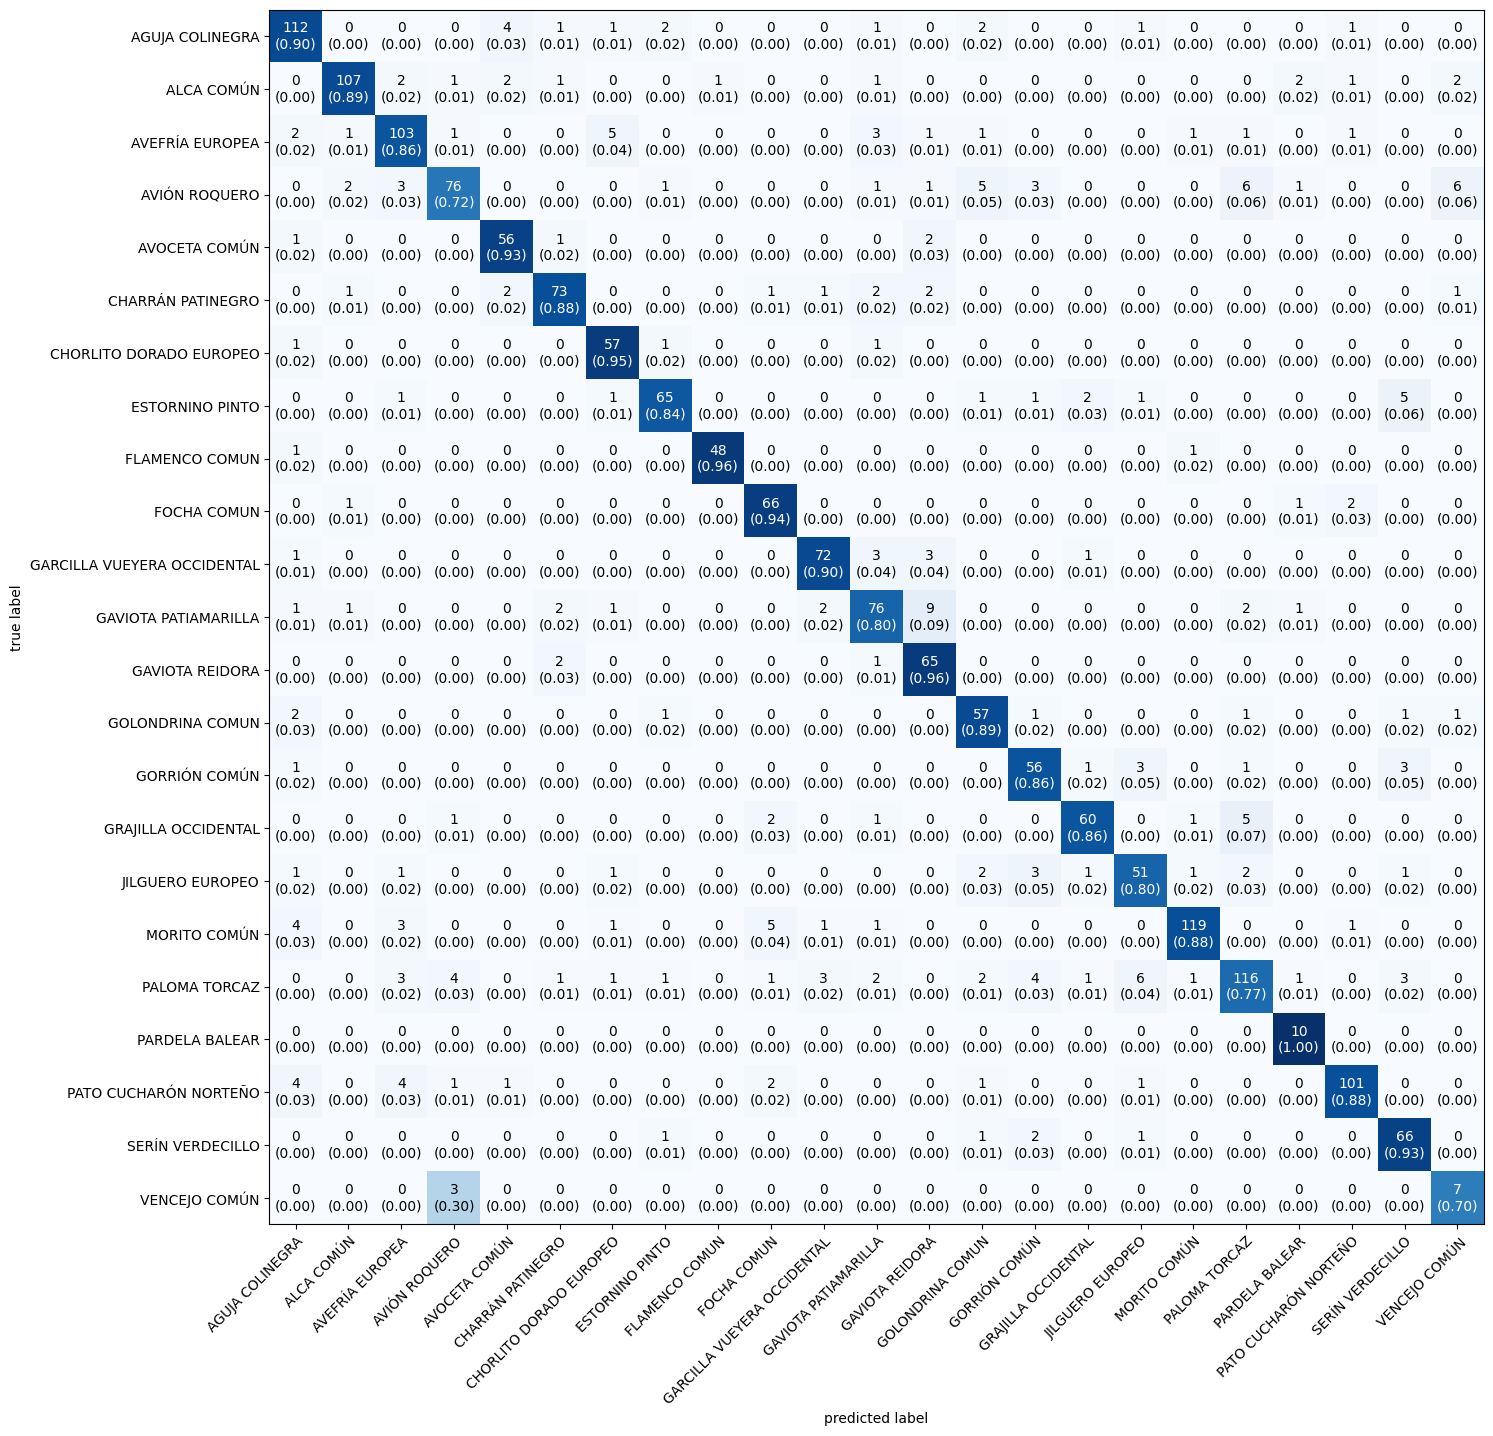

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline

# Definir el generador de datos de prueba
test_data_dir = r'C:\Users\johns\Desktop\TFG\Dataset\test'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(height_shape, width_shape),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Load the model
custom_Model= load_model(r'C:\Users\johns\Desktop\TFG\Dataset\RESNET152V2 - 23 clases\custom_resnetv2_NAmodel.h5')

# Make predictions
predictions = custom_Model.predict_generator(generator=test_generator, steps=len(test_generator))
y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes

# Map class names to class indices
class_indices = test_generator.class_indices
names = list(class_indices.keys())

# Generate confusion matrix
conf_matrix = confusion_matrix(y_real, y_pred)

# Plot confusion matrix
plt.figure(figsize=(15, 15))

plot_confusion_matrix(conf_mat=conf_matrix, figsize=(15, 15), class_names=names, show_normed=True)
plt.tight_layout()

# Print classification report
print(classification_report(y_real, y_pred, digits = 4))

In [7]:
print(y_real)

[ 0  0  0 ... 22 22 22]


In [8]:
print(y_pred)

[20  0  0 ... 22 22  3]
